# Augmentation

In [1]:
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.xtras import *

In [2]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [11]:
bs = 1024
dls = get_dls()
cbs = get_cbs(accuracy=MulticlassAccuracy())

In [12]:
set_seed(42)
lr,epochs = 6e-2,5

In [13]:
nfs = [16,32,64,128,256]

def get_model(act=nn.ReLU):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=nn.BatchNorm2d)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(init_weights)

accuracy,loss,epoch,train,time
0.808,0.547,0,True,00:02
0.862,0.384,0,False,00:00
0.895,0.285,1,True,00:02
0.865,0.380,1,False,00:00
0.905,0.255,2,True,00:02
0.865,0.380,2,False,00:00
0.916,0.229,3,True,00:02
0.873,0.371,3,False,00:00
0.925,0.203,4,True,00:02
0.887,0.328,4,False,00:00


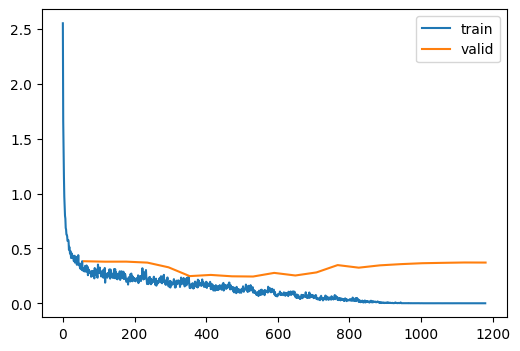

In [15]:
epochs, lr  = 20, 3e-2
xtras = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

In [16]:
from torchvision.transforms import v2

In [36]:
BatchTransformCB??

In [23]:
class BatchtfmCB(Callback):
    def __init__(self, tfmx=fc.noop, tfmy=fc.noop): fc.store_attr()
    def before_batch(self, learn): learn.batch = self.tfmx(learn.batch[0]), self.tfmy(learn.batch[1])

In [33]:
tfms = nn.Sequential(
#     v2.RandomResizedCrop(size=(28, 28), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ToDtype(torch.float32, scale=True)
)

In [34]:
model = get_model()
b_tfms = Batchtfm(tfmx=tfms)
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB(), b_tfms])

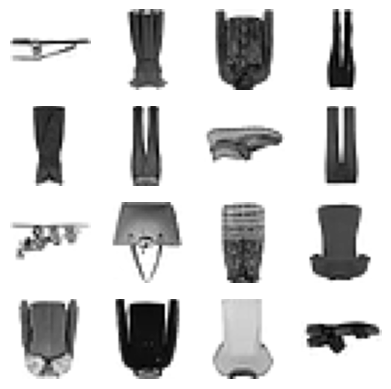

In [35]:
learn.fit(1)
xb, yb = learn.batch
show_images(xb[:16], imsize=1.2)

In [7]:
from torchvision.transforms import v2

H, W = 32, 32
img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)

transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img = transforms(img)